In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SPAM text message 20170820 - Data.csv", encoding="latin1")

# For some reasons, the column names must be "text" and "label".
dataset = pd.DataFrame(raw, columns=["Category","Message"]).rename(columns={"Category": "label", "Message": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})

train, test = train_test_split(dataset, test_size=.25, random_state=42)

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from datasets import Dataset

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize(batch):
  return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

train_set = Dataset.from_pandas(train)
test_set = Dataset.from_pandas(test)

train_set = train_set.map(
    tokenize,
    batched=True
)
test_set = test_set.map(
    tokenize,
    batched=True
)

train_set = train_set.with_format("torch")
test_set = test_set.with_format("torch")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/4179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1393 [00:00<?, ? examples/s]

In [ ]:
from transformers import (
    Trainer, TrainingArguments
)
from datasets import Dataset
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support)
import numpy as np

distilbert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

def compute_metrics(pred):
  logits, labels = pred
  preds = np.argmax(logits, axis=-1)

  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")

  return {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1": f1
  }

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Notebooks/results-distilBERT",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    logging_dir="/content/drive/MyDrive/Colab Notebooks/log",
    save_total_limit=1,
    report_to="none",
    learning_rate=2e-5,
)

trainer = Trainer(
    model=distilbert,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.075100,0.040354,0.990668,0.972678,0.956989,0.964770
2,0.028700,0.042401,0.991385,0.978022,0.956989,0.967391


TrainOutput(global_step=1046, training_loss=0.04968572563240679, metrics={'train_runtime': 211.8386, 'train_samples_per_second': 39.455, 'train_steps_per_second': 4.938, 'total_flos': 553581258983424.0, 'train_loss': 0.04968572563240679, 'epoch': 2.0})

# Eval Phase

In [ ]:
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification)
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results-distilBERT/checkpoint-1046"
trained_distilbert = DistilBertForSequenceClassification.from_pretrained(checkpoint)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trained_distilbert.eval()

# raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding="latin1")
# dataset = pd.DataFrame(raw, columns=["v1","v2"]).rename(columns={"v1": "label", "v2": "text"})
raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SPAM text message 20170820 - Data.csv", encoding="latin1")
dataset = pd.DataFrame(raw, columns=["Category","Message"]).rename(columns={"Category": "label", "Message": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})
train, test = train_test_split(dataset, test_size=.16, random_state=42)

inputs = tokenizer(test["text"].tolist(), truncation=True, padding=True, return_tensors="pt")
with torch.no_grad():
    outputs = trained_distilbert(**inputs)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)


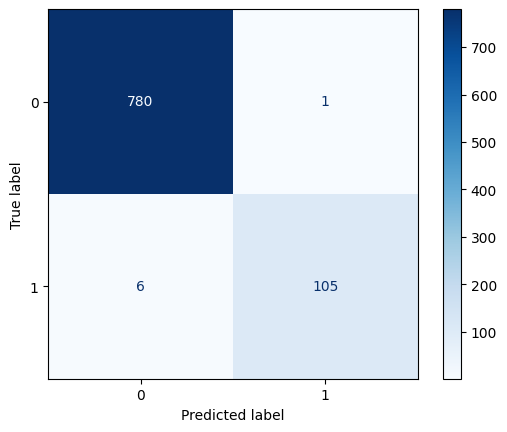

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(test["label"], predictions.numpy())

ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot(values_format="d", cmap="Blues")
plt.show()

# Prediction

In [ ]:
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification)
import torch

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results-distilBERT/checkpoint-1046"
trained_distilbert = DistilBertForSequenceClassification.from_pretrained(checkpoint)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
trained_distilbert.eval()

def predict(msg:str):
  input = tokenizer(msg, truncation=True, padding=True, return_tensors="pt")
  with torch.no_grad():
    output = trained_distilbert(**input)
  proba = torch.softmax(output.logits, dim=1)
  prediction = torch.argmax(proba).item()
  return prediction, proba.squeeze().tolist()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
ham_test = "I'm in a meeting, call me later at"
ham_2 = "Do �_ noe if ben is going?"
# What in the world?
ham_3 = "My slave! I want you to take 2 or 3 pictures of yourself today in bright light on your cell phone! Bright light!"


spam_test = "Want to funk up ur fone with a weekly new tone reply TONES2U 2 this text. www.ringtones.co.uk, the original n best. Tones 3GBP network operator rates apply"
spam_2 = "Urgent Please call 09066612661 from landline. �5000 cash or a luxury 4* Canary Islands Holiday await collection. T&Cs SAE award. 20M12AQ. 150ppm. 16+ ���"
pred, prob = predict(spam_2)
print({"Prediction": pred, "Probability": prob})

{'Prediction': 1, 'Probability': [0.0007438793545588851, 0.9992560744285583]}


# ROC Curve

In [1]:
import torch
from torch.nn.functional import softmax

def get_probabilities(model, tokenizer, texts):
    model.eval()
    all_probs = []
    with torch.no_grad():
        for t in texts:
            inputs = tokenizer(t, return_tensors="pt", truncation=True)
            outputs = model(**inputs)
            logits = outputs.logits
            probs = softmax(logits, dim=1)
            all_probs.append(probs[0,1].item())
    return all_probs

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification)

checkpoint = "/content/drive/MyDrive/Colab Notebooks/results-distilBERT/checkpoint-1046"
trained_distilbert = DistilBertForSequenceClassification.from_pretrained(checkpoint)
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/spam.csv", encoding="latin1")
dataset = pd.DataFrame(raw, columns=["v1","v2"]).rename(columns={"v1": "label", "v2": "text"})
# raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SPAM text message 20170820 - Data.csv", encoding="latin1")
# dataset = pd.DataFrame(raw, columns=["Category","Message"]).rename(columns={"Category": "label", "Message": "text"})
dataset["label"] = dataset["label"].map({"ham": 0, "spam": 1})
y_true = dataset["label"].tolist()

distilbert_probs = get_probabilities(trained_distilbert, tokenizer, dataset["text"].tolist())

fpr_r, tpr_r, _ = roc_curve(y_true, distilbert_probs)
roc_auc_r = auc(fpr_r, tpr_r)

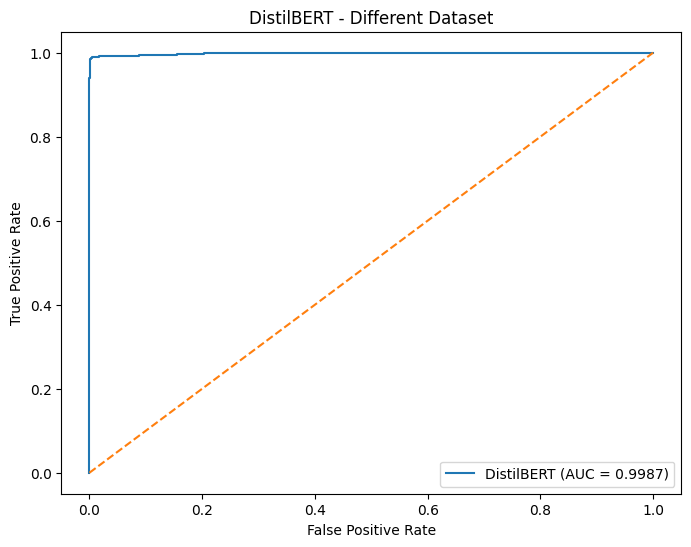

In [5]:
plt.figure(figsize=(8,6))

plt.plot(fpr_r, tpr_r, label=f"DistilBERT (AUC = {roc_auc_r:.4f})")

plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DistilBERT - Different Dataset")
plt.legend(loc="lower right")

plt.show()